## FINAL

In [1]:
## CARGAR LIBRERIAS

In [2]:
#Ignorar los warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from numpy import vectorize


# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, f_regression, chi2, mutual_info_regression, SelectPercentile, SelectFpr, SelectFdr, SelectFwe, GenericUnivariateSelect
from sklearn.feature_selection import VarianceThreshold

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline



In [3]:
## FUNCIÓN PARA DESFASE

In [4]:
# Función para transformar datos crudos en datos para el aprendizaje de una serie de tiempo
def desfasar(data, n_atras=1, n_adelante=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dfd = pd.DataFrame(data)
    cols, names = list(), list()
    aux=dfd.columns.values
    # Secuencia de entrada (t-n, ... t-1)
    for i in range(n_atras, 0, -1):
        cols.append(dfd.shift(i))
        names += [f'{aux[j]}(t-{i})' for j in range(n_vars)]
    # Secuencia de pronostico (t, t+1, ... t+n)
    for i in range(0, n_adelante+1):
        cols.append(dfd.shift(-i))
        if i == 0:
            names += [f'{aux[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{aux[j]}(t+{i})' for j in range(n_vars)]
    # Juntar toda la informacion
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Eliminar los registros con valores NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
## FUNCION PARA ESCALADO

In [6]:

#Función para escalar los datos, recibe dato a escalar (vector), minimo y maximo 
def escala(x,mi,ma):
    return (x-mi)/(ma-mi)

escalador = vectorize(escala)

#Ejemplo de uso
#   values[:,0]=escalador(values[:,0],0,300)

def Reescala(x,mi,ma):
    return x*(ma-mi)+mi

Reescalador = vectorize(Reescala)


In [7]:
## FUNCION PARA SELECCION DE CARACTERISTICAS

In [8]:

def seleccion(param,n):
    plt.figure(1,figsize=(10,5))
    plt.clf()

    X_indices = np.arange(X.shape[-1])

    # #############################################################################
    # Univariate feature selection with F-test for feature scoring
    # We use the default selection function to select the four
    # most significant features
    selector = SelectKBest(param, k=n)
    selector.fit(x_train, y_train)
    #print("p_values: ",selector.pvalues_)
    scores = selector.scores_
    mask = selector.get_support() #list of booleans
    new_features = [] # The list of your K best features

    for bool, feature,score in zip(mask, feature_names,scores):
        if bool:
            new_features.append([feature,score])

    #print('caracteristicas: ',sorted(new_features, key = lambda x: x[1], reverse=True))
    # #############################################################################
    # Compare to the weights of an SVM
    clf = make_pipeline(MinMaxScaler(), SVR(kernel='linear'))
    clf.fit(x_train, y_train)
    print('Classification accuracy without selecting features: {}'
          .format(clf.score(x_test, y_test)))

    svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
    svm_weights /= svm_weights.sum()

    plt.bar(X_indices , svm_weights, width=.5, label='SVM weight')#- .25

    clf_selected = make_pipeline(
            SelectKBest(param, k=n), MinMaxScaler(), SVR( kernel='linear')
    )
    clf_selected.fit(x_train, y_train)
    
    print('Classification accuracy after univariate feature selection: {}'
          .format(clf_selected.score(x_test, y_test)))
    aux = clf_selected.score(x_test, y_test) # para retornar valor 
    svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
    svm_weights_selected /= svm_weights_selected.sum()

    plt.bar(X_indices[selector.get_support()], svm_weights_selected,
            width=.5, label='SVM weights after selection') # - .05


    plt.title("Comparing feature selection")
    plt.xlabel('Feature number')
    #plt.yticks(())
    plt.grid()
    plt.axis('tight')
    plt.legend(loc='upper right')
    plt.show()
    return aux
    

In [9]:
## LECTURA DE DATOS Y DEFINICIÓN DE PARAMETROS

In [10]:
Ciudad = 'BARRANQUILLA/'
DATA = 'barranquilla_consolidado_2013_2020.csv'
PATH_I = 'D:/DENGUE_CODIGO/'
PATH_O = PATH_I + Ciudad + 'RESULTADOS/DENGUE/'

FILE = PATH_I + 'DATOS_BASE/' + DATA 

#Lectura de datos diarios
df1 = pd.read_csv(FILE, index_col=None, parse_dates=True)
df1 = df1.interpolate()

# Variables globales
desfase = 23
n_semanas = 53
title_string = 'Casos de Dengue'
nombre_a = 'caracteristicas_24.csv'
nombre_g = 'rendimiento_24.jpg'
df1

,FECHA,COD_DPTO,COD_MUNICIPIO,POBLACION,ANO,SEMANA,PRECIPITATION,DRY_DAYS,TEMPERATURE_AMAX,REL_HUMIDITY_AMAX,...,MEI,ONI,SST1+2,SST3,SST4,SST3.4,TNI,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
0,14/04/2013,8.0,8001.0,1206946.0,2013.0,16.0,3.2,5.0,32.921712,93.0,...,-0.370000,-0.210000,24.740000,27.350000,28.470000,27.680000,-1.528000,91.0,1.0,0.0
1,21/04/2013,8.0,8001.0,1206946.0,2013.0,17.0,0.0,7.0,32.506878,93.0,...,-0.370000,-0.210000,24.740000,27.350000,28.470000,27.680000,-1.528000,99.0,1.0,0.0
2,28/04/2013,8.0,8001.0,1206946.0,2013.0,18.0,32.2,6.0,31.859918,94.0,...,-0.564286,-0.244286,23.682857,26.801429,28.607143,27.617143,-1.757143,81.0,0.0,0.0
3,05/05/2013,8.0,8001.0,1206946.0,2013.0,19.0,12.6,6.0,34.700000,98.0,...,-0.710000,-0.270000,22.890000,26.390000,28.710000,27.570000,-1.929000,92.0,2.0,0.0
4,12/05/2013,8.0,8001.0,1206946.0,2013.0,20.0,0.0,7.0,32.900000,99.0,...,-0.710000,-0.270000,22.890000,26.390000,28.710000,27.570000,-1.929000,81.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,NaN,8.0,8001.0,1232462.0,2018.0,52.0,0.0,7.0,31.600000,88.0,...,0.130000,0.810000,23.600000,26.120000,29.520000,27.530000,-1.700000,42.0,0.0,0.0
362,NaN,8.0,8001.0,1232462.0,2018.0,52.0,0.0,7.0,31.600000,88.0,...,0.130000,0.810000,23.600000,26.120000,29.520000,27.530000,-1.700000,42.0,0.0,0.0
363,NaN,8.0,8001.0,1232462.0,2018.0,52.0,0.0,7.0,31.600000,88.0,...,0.130000,0.810000,23.600000,26.120000,29.520000,27.530000,-1.700000,42.0,0.0,0.0
364,NaN,8.0,8001.0,1232462.0,2018.0,52.0,0.0,7.0,31.600000,88.0,...,0.130000,0.810000,23.600000,26.120000,29.520000,27.530000,-1.700000,42.0,0.0,0.0


In [11]:
## EXTRACCION DE LOS DATOS A SER USADOS

In [12]:
#Extraer los datos climaticos y del niño
#XS=df1[['PRECIPITATION', 'DRY_DAY', 'TEMPERATURE_AMAX', 'REL_HUMIDITY_AMAX', 'TEMPERATURE_AMIN', 'REL_HUMIDITY_AMIN', 'TEMPERATURE_MEAN', 'TEMPERATURE_RANGE', 'REL_HUMIDITY_MEAN', 'MEI', 'ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4', 'TNI', 'DENGUE']]
XS=df1[['DENGUE']]


#Extraer el numero de casos de Dengue y generar las salidas para los datos desfasados
out = XS['DENGUE']
out = out[desfase+1:].values


#Hallar los datos desfasados
XS = desfasar(XS, 0, desfase)

XS = XS.drop(XS.index[len(XS)-1])

#Insertar la salida, para formar el conjunto de datos
XS.insert(XS.shape[1],'DENGUE_ESPERADO',out)
print(XS.shape)

#Guardar el archivo de datos desfasados con toda la informacion generada
XS.to_csv(PATH_O + 'datos_semana_desfase_23_todos.csv', index=True)

#Extraer solo los datos requeridos para el entrenamiento

# , 'DENGUE(t+15)', 'DENGUE(t+14)', 'DENGUE(t+13)', 'DENGUE(t+12)', 'DENGUE(t+11)', 'DENGUE(t+10)', 'DENGUE(t+9)', 'DENGUE(t+8)', 'DENGUE(t+7)', 'DENGUE(t+6)', 'DENGUE(t+5)', 'DENGUE(t+4)', 'DENGUE(t+3)', 'DENGUE(t+2)', 'DENGUE(t+1)', 'DENGUE(t)',

XS_REAL = XS[['DENGUE(t+23)', 'DENGUE(t+22)', 'DENGUE(t+21)', 'DENGUE(t+20)', 'DENGUE(t+19)', 'DENGUE(t+18)', 'DENGUE(t+17)', 'DENGUE(t+16)', 'DENGUE(t+15)', 'DENGUE(t+14)', 'DENGUE(t+13)', 'DENGUE(t+12)', 'DENGUE(t+11)', 'DENGUE(t+10)', 'DENGUE(t+9)', 'DENGUE(t+8)', 'DENGUE(t+7)', 'DENGUE(t+6)', 'DENGUE(t+5)', 'DENGUE(t+4)', 'DENGUE(t+3)', 'DENGUE(t+2)', 'DENGUE(t+1)', 'DENGUE(t)', 'DENGUE_ESPERADO']]

# XS_REAL = XS[['MEI(t)', 'ONI(t)', 'SST1+2(t)', 'SST3(t)', 'SST4(t)', 'SST3.4(t)', 'TNI(t)', 'MEI(t+4)', 'ONI(t+4)', 'SST1+2(t+4)', 'SST3(t+4)', 'SST4(t+4)', 'SST3.4(t+4)', 'TNI(t+4)', 'MEI(t+8)', 'ONI(t+8)', 'SST1+2(t+8)', 'SST3(t+8)', 'SST4(t+8)', 'SST3.4(t+8)', 'TNI(t+8)', 'MEI(t+12)', 'ONI(t+12)', 'SST1+2(t+12)', 'SST3(t+12)', 'SST4(t+12)', 'SST3.4(t+12)', 'TNI(t+12)', 'MEI(t+16)', 'ONI(t+16)', 'SST1+2(t+16)', 'SST3(t+16)', 'SST4(t+16)', 'SST3.4(t+16)', 'TNI(t+16)', 'MEI(t+20)', 'ONI(t+20)', 'SST1+2(t+20)', 'SST3(t+20)', 'SST4(t+20)', 'SST3.4(t+20)', 'TNI(t+20)', 'DENGUE_ESPERADO']]

print(XS_REAL.shape)
df = XS_REAL
df

(342, 25)
(342, 25)


,DENGUE(t+23),DENGUE(t+22),DENGUE(t+21),DENGUE(t+20),DENGUE(t+19),DENGUE(t+18),DENGUE(t+17),DENGUE(t+16),DENGUE(t+15),DENGUE(t+14),...,DENGUE(t+8),DENGUE(t+7),DENGUE(t+6),DENGUE(t+5),DENGUE(t+4),DENGUE(t+3),DENGUE(t+2),DENGUE(t+1),DENGUE(t),DENGUE_ESPERADO
0,85.0,81.0,65.0,79.0,62.0,74.0,64.0,74.0,84.0,78.0,...,87.0,77.0,106.0,92.0,81.0,92.0,81.0,99.0,91.0,96.0
1,96.0,85.0,81.0,65.0,79.0,62.0,74.0,64.0,74.0,84.0,...,89.0,87.0,77.0,106.0,92.0,81.0,92.0,81.0,99.0,86.0
2,86.0,96.0,85.0,81.0,65.0,79.0,62.0,74.0,64.0,74.0,...,85.0,89.0,87.0,77.0,106.0,92.0,81.0,92.0,81.0,84.0
3,84.0,86.0,96.0,85.0,81.0,65.0,79.0,62.0,74.0,64.0,...,91.0,85.0,89.0,87.0,77.0,106.0,92.0,81.0,92.0,100.0
4,100.0,84.0,86.0,96.0,85.0,81.0,65.0,79.0,62.0,74.0,...,101.0,91.0,85.0,89.0,87.0,77.0,106.0,92.0,81.0,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,...,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0
338,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,...,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0
339,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,...,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0
340,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,...,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0


In [13]:
## GENERAR DATOS DE ENTRENAMIENTO, EVALUACIÓN Y PRONOSTICO

In [14]:
#Separacion de entradas y salidas
XS_REAL = XS_REAL.values
X = XS_REAL[:,:-1]
Y = XS_REAL[:,-1]

#Numero de datos para el entrenamiento
n_train = int(0.75*len(Y))

#Numero de datos para test
n_test = len(Y) - n_train

#print("Cantidad total de datos = ",len(endog_y),"\nNumero de datos para pronostico = ", n_pronostico,"\nNumero de datos para entrenamiento = ",n_train,"\nNumero de datos para test = ",n_test)

print(n_train,n_test)


x_train = X[0:n_train,:]
x_test = X[n_train:n_train+n_test,:]
y_train = Y[0:n_train]
y_test = Y[n_train:n_train+n_test]
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)



256 86
(256, 24) (86, 24) (256,) (86,)


In [15]:
#Crear una matriz con los limites para el esclalado de los datos
limites=np.array(([np.amin(XS_REAL[:,0])],[np.amax(XS_REAL[:,0])]))

for i in range(1,len(XS_REAL[1,:])):
    limites=np.insert(limites, limites.shape[1], [np.amin(XS_REAL[:,i]), np.amax(XS_REAL[:,i])], axis=1)

print(limites.shape)

(2, 25)


In [16]:

scaled = np.zeros((len(XS_REAL), len(XS_REAL[0])))
for i in range(0,len(XS_REAL[1,:])):
    scaled[:,i]=escalador(XS_REAL[:,i],limites[0][i],limites[1][i])
    
x, y = scaled[:, :-1], scaled[:, -1]
print(scaled.shape)


(342, 25)


In [17]:
# nombres de las columnas
feature_names = list(df.columns.values)
feature_names

['DENGUE(t+23)',
 'DENGUE(t+22)',
 'DENGUE(t+21)',
 'DENGUE(t+20)',
 'DENGUE(t+19)',
 'DENGUE(t+18)',
 'DENGUE(t+17)',
 'DENGUE(t+16)',
 'DENGUE(t+15)',
 'DENGUE(t+14)',
 'DENGUE(t+13)',
 'DENGUE(t+12)',
 'DENGUE(t+11)',
 'DENGUE(t+10)',
 'DENGUE(t+9)',
 'DENGUE(t+8)',
 'DENGUE(t+7)',
 'DENGUE(t+6)',
 'DENGUE(t+5)',
 'DENGUE(t+4)',
 'DENGUE(t+3)',
 'DENGUE(t+2)',
 'DENGUE(t+1)',
 'DENGUE(t)',
 'DENGUE_ESPERADO']

In [18]:
x_train_s = x[0:n_train,:]
x_test_s = x[n_train:n_train+n_test,:]
y_train_s = y[0:n_train]
y_test_s = y[n_train:n_train+n_test]
print(x_train_s.shape,x_test_s.shape,y_train_s.shape,y_test_s.shape)

(256, 24) (86, 24) (256,) (86,)


In [19]:
# ¿ESTO NO SE ESTA USANDO? ------------------------------------------------

V=np.var(x_train_s, axis=0)
print(V.shape)
sel = VarianceThreshold(threshold=0.01)    
X2 = sel.fit_transform(x_train_s)
print(X2.shape)
print(X2)

# sel_chi2 = SelectKBest (chi2, k = 4) # seleccionar 4 características 
# X_train_chi2 = sel_chi2.fit_transform (x_train_s, y_train_s) 
# print (sel_chi2.get_support ())

(24,)
(256, 24)
[[0.42079208 0.4009901  0.32178218 ... 0.4009901  0.49009901 0.45049505]
 [0.47524752 0.42079208 0.4009901  ... 0.45544554 0.4009901  0.49009901]
 [0.42574257 0.47524752 0.42079208 ... 0.4009901  0.45544554 0.4009901 ]
 ...
 [0.1980198  0.16336634 0.18811881 ... 0.06930693 0.07920792 0.06930693]
 [0.22277228 0.1980198  0.16336634 ... 0.06435644 0.06930693 0.07920792]
 [0.17326733 0.22277228 0.1980198  ... 0.05940594 0.06435644 0.06930693]]


25
caracteristicas:  1
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -6.584547725700361


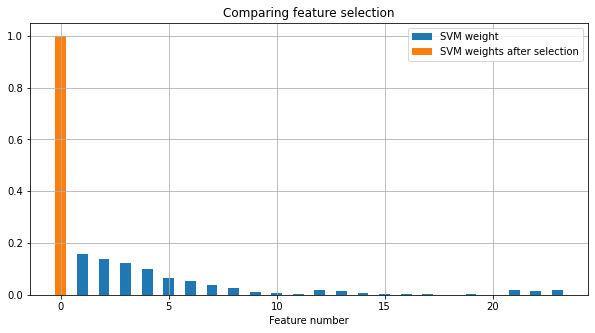

caracteristicas:  2
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -4.625909130766547


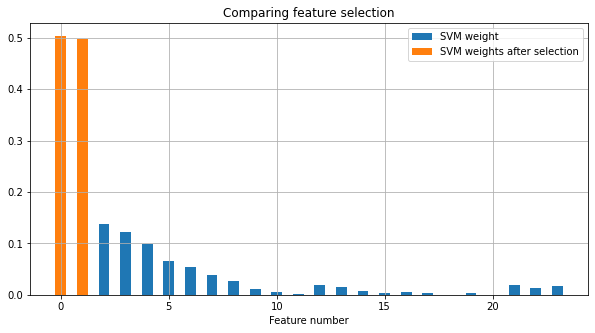

caracteristicas:  3
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -3.4932481271133398


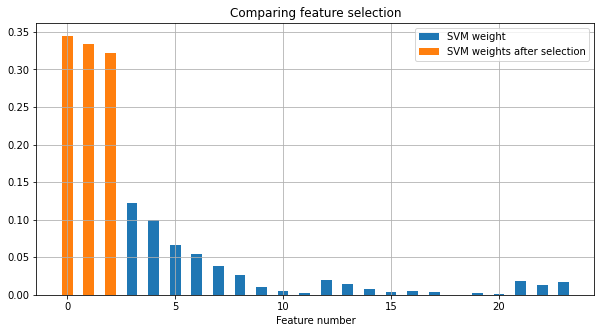

caracteristicas:  4
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.9141269383389434


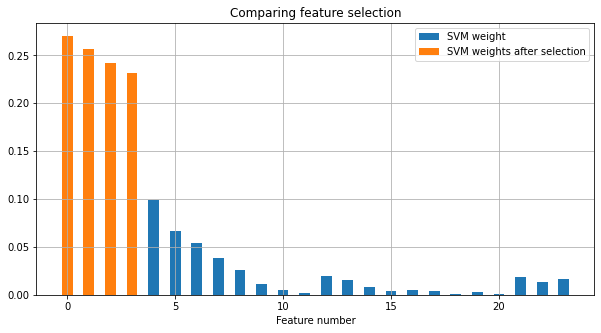

caracteristicas:  5
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.900260403701398


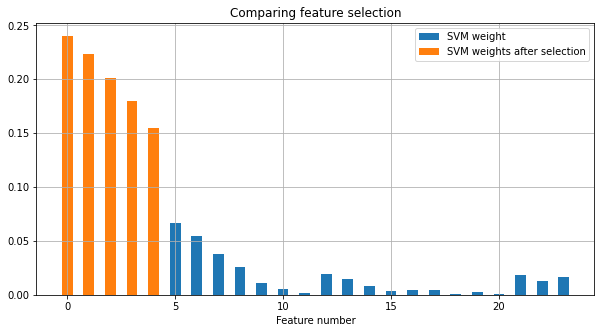

caracteristicas:  6
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.5742813556450708


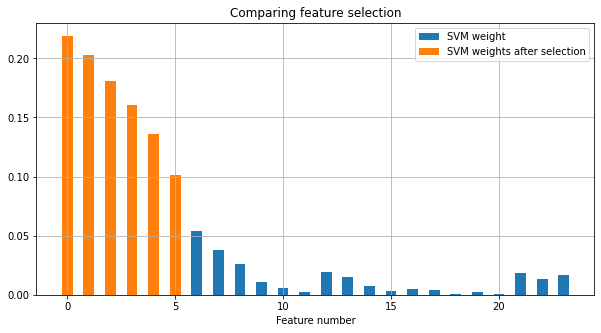

caracteristicas:  7
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.3565420339182777


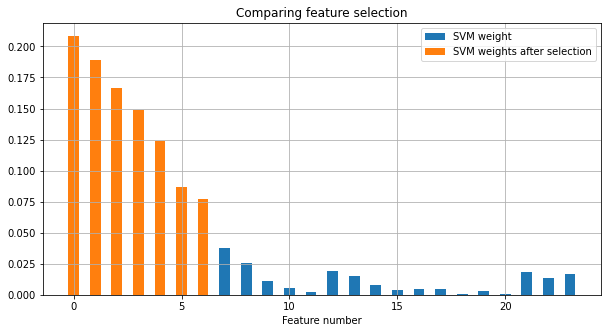

caracteristicas:  8
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.370442951045289


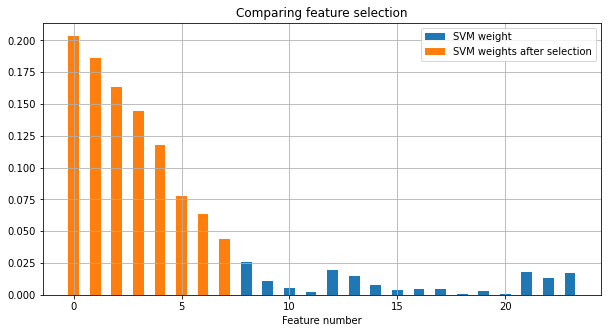

caracteristicas:  9
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.3910773632960804


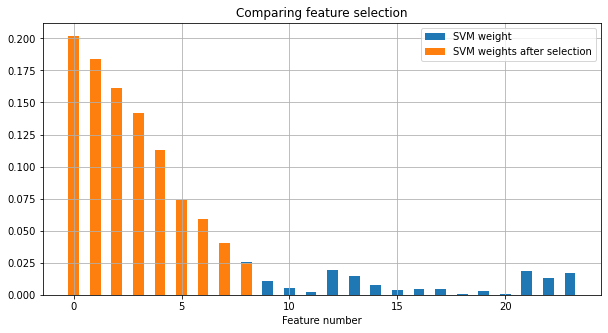

caracteristicas:  10
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.3968797379577835


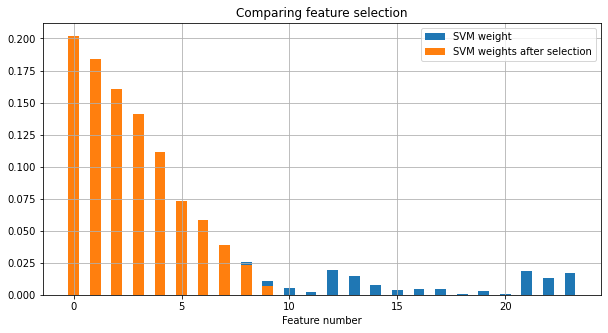

caracteristicas:  11
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.385739898112286


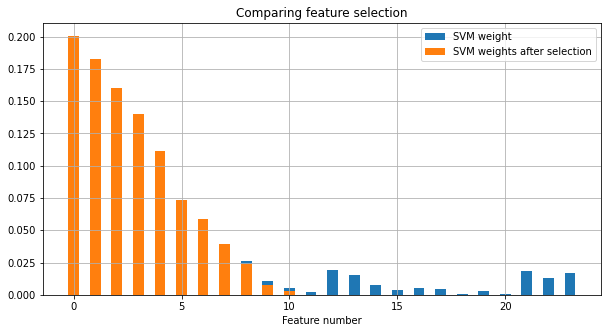

caracteristicas:  12
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.404240955836974


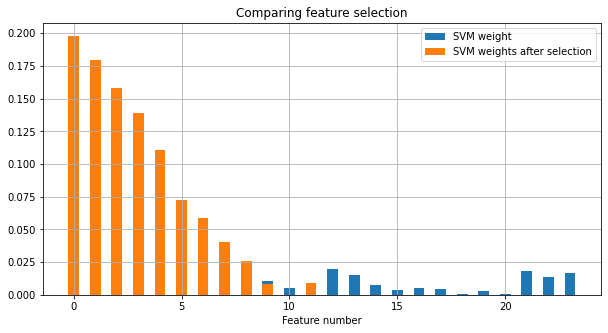

caracteristicas:  13
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.452525230335923


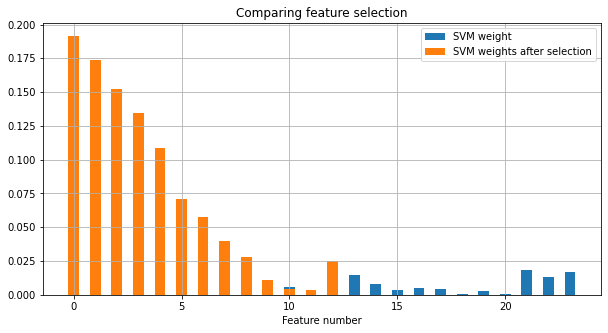

caracteristicas:  14
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.506448488662448


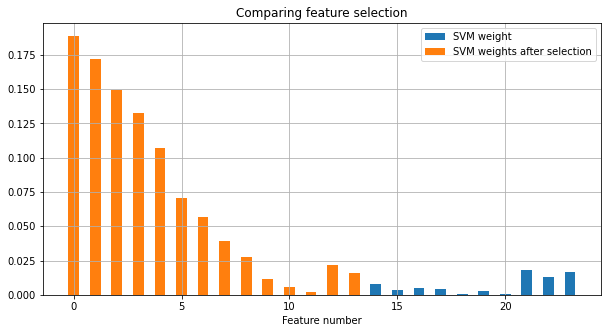

caracteristicas:  15
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.492034131677705


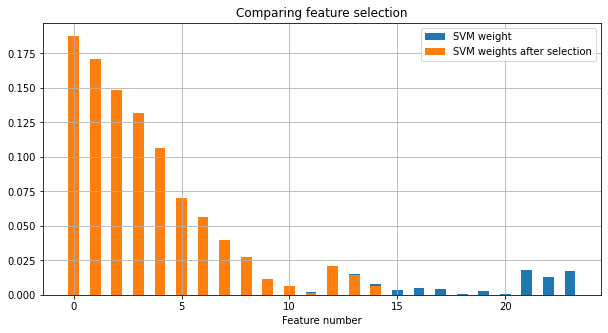

caracteristicas:  16
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.492562044802461


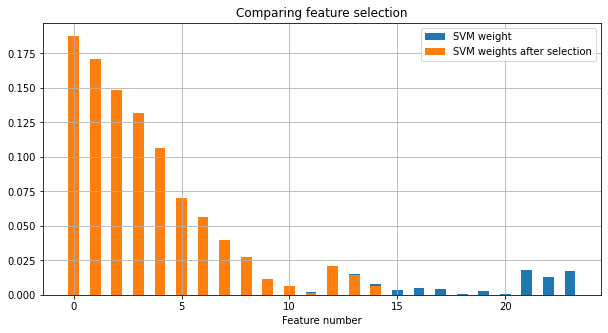

caracteristicas:  17
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.49284576326073


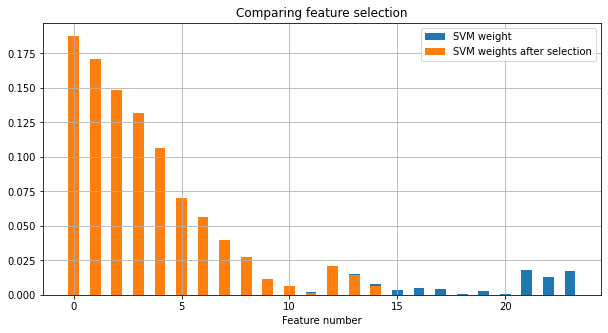

caracteristicas:  18
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.508546961197952


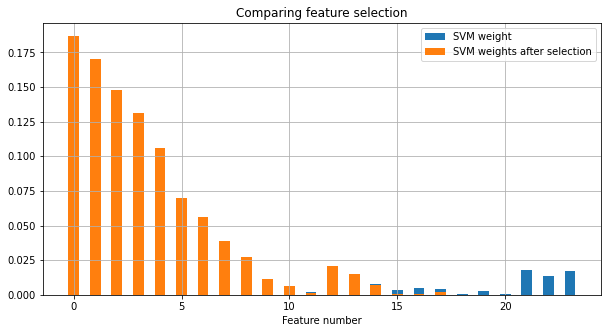

caracteristicas:  19
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.5110978002047304


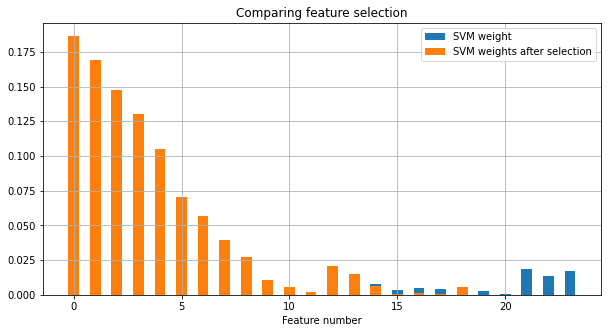

caracteristicas:  20
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.4751724743230805


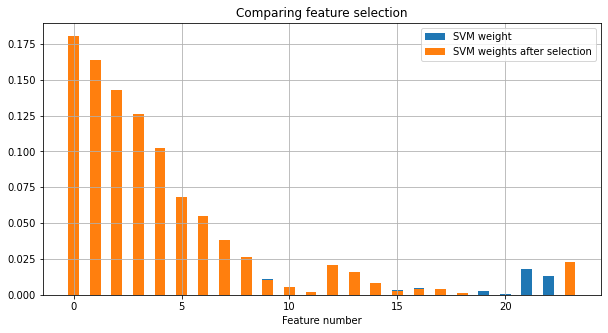

caracteristicas:  21
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.4717956060040116


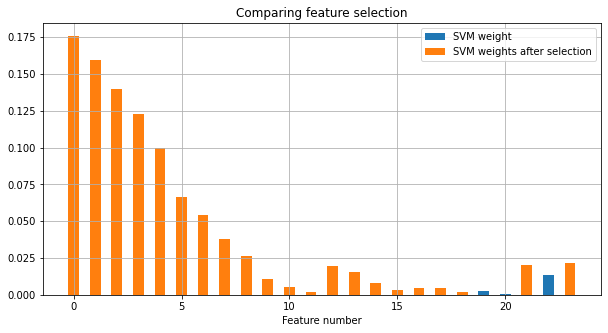

caracteristicas:  22
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.481969825599866


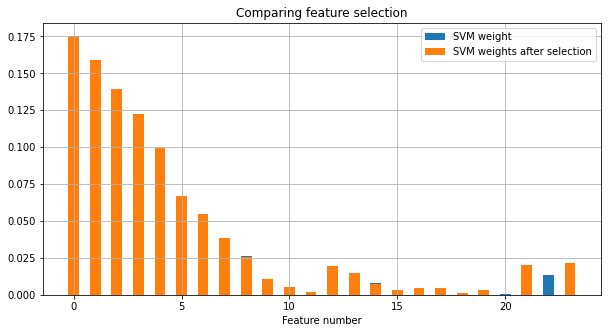

caracteristicas:  23
Classification accuracy without selecting features: -2.487810288997682
Classification accuracy after univariate feature selection: -2.4887481580903983


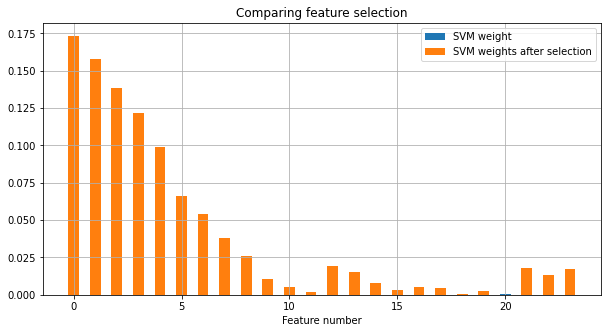

In [20]:
#Definir el numero de variables que seran usadas en la seleccion de cacteristicas
n_var = XS_REAL.shape[1]     # NUMERO DE VARIABLES
print(n_var)
score_maquinas=[]
for i in range(1,n_var-1):
    print("caracteristicas: ",i)
    val=seleccion(f_regression,i) #valor F anova
    score_maquinas.append([feature_names[i], abs(val)])

    
#     #print(len(score_maquinas))

#     plt.figure(1,figsize=(20,10))
#     plt.clf()
#     X_indices = np.arange(len(score_maquinas))
#     print(score_maquinas[i][1])
#     plt.bar(X_indices , score_maquinas[i][1], width=.5, label='score') #- .45
#     plt.title("'rendimiento maquinas'")
#     plt.xlabel('Feature number')
#     #plt.yticks(())
#     plt.grid()
#     plt.axis('tight')
#     plt.legend(loc='upper right')

#     plt.savefig(nombre_g, dpi=300)
#     plt.show()     


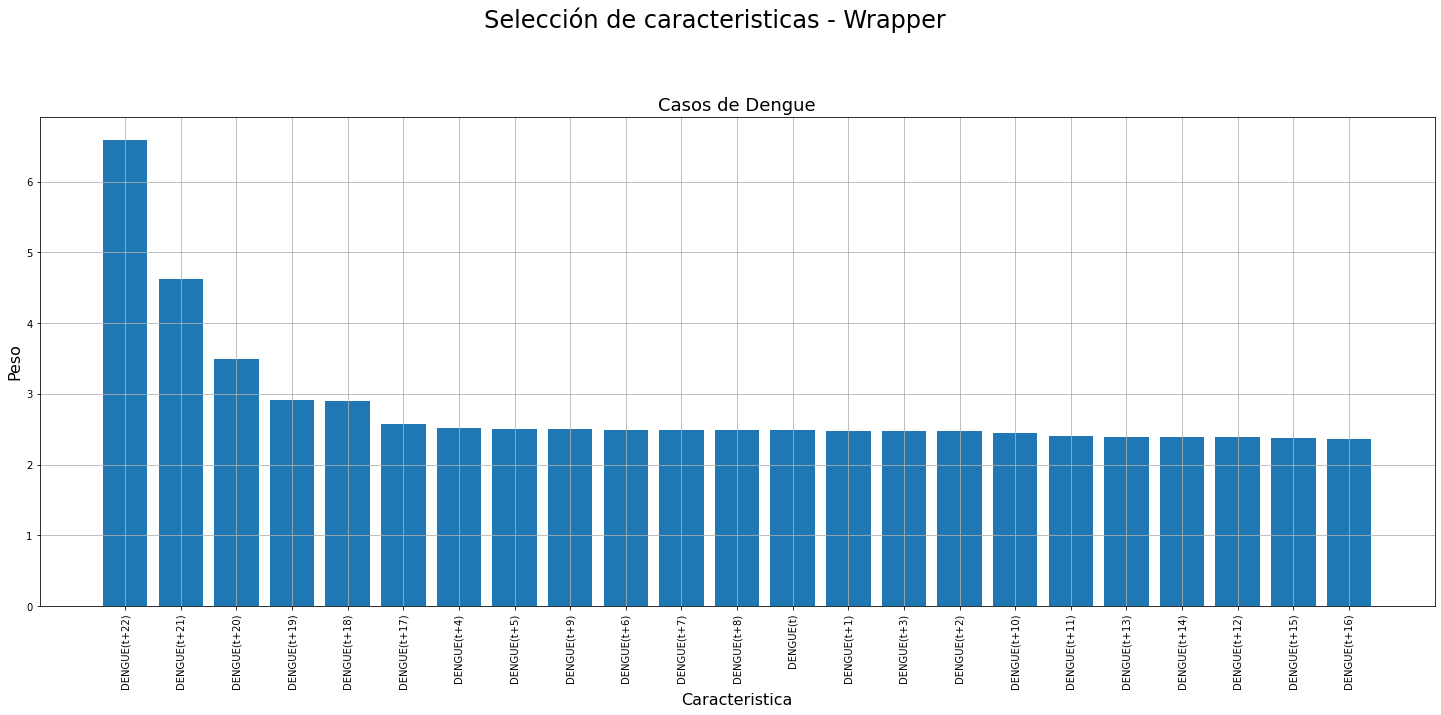

In [21]:
score_maquinas_orden = sorted(score_maquinas, key = lambda x: x[1], reverse=True)
df_score_maquinas_orden = pd.DataFrame(score_maquinas_orden)
df_score_maquinas_orden

df_score_maquinas_orden.to_csv(PATH_O + 'caracteristicas_Wrapper_ordenado.csv', index=True)

x_g = df_score_maquinas_orden[0]
y_g = df_score_maquinas_orden[1]

plt.figure(1,figsize=(25,9))

plt.y_pos = np.arange(len(df_score_maquinas_orden))
plt.bar(x_g, y_g)
X_indices = np.arange(len(df_score_maquinas_orden))
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Wrapper', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.xticks(X_indices, x_g, rotation='vertical', fontsize = 10)
# ax.set_xscale('log')
#ax.invert_yaxis()
plt.grid()
plt.savefig(PATH_O + 'Wrapper_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show()

#score_maquinas_orden


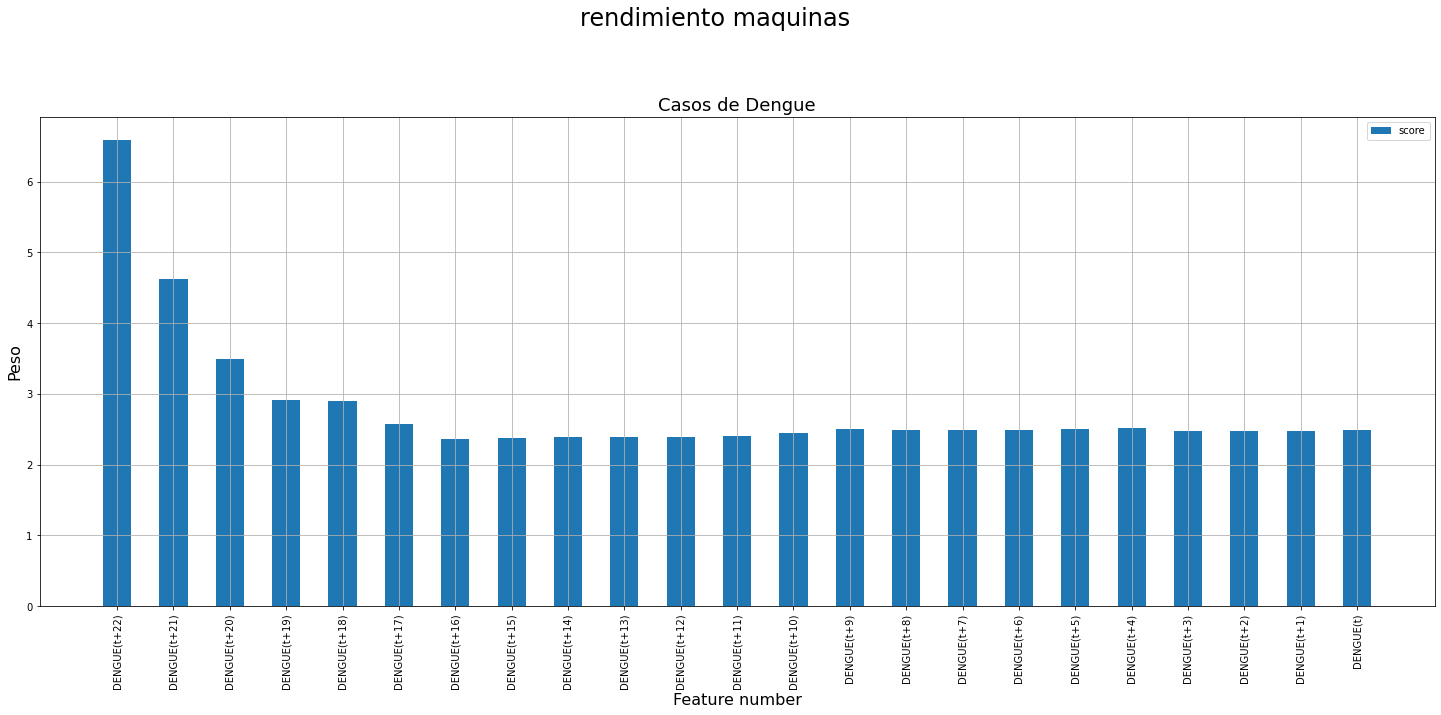

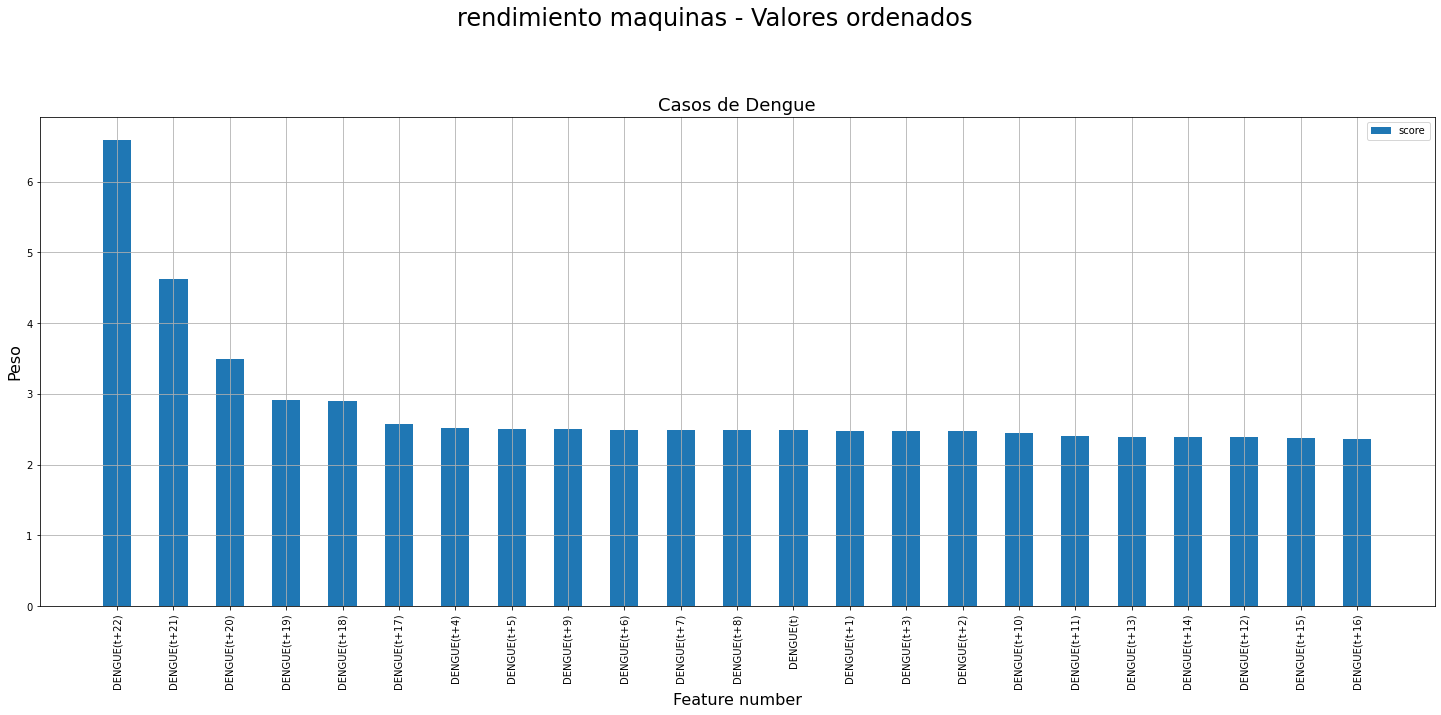

In [22]:
#print(len(score_maquinas))

df_score_maquinas = pd.DataFrame(score_maquinas)

plt.figure(1,figsize=(25,9))
plt.clf()
X_indices = np.arange(len(score_maquinas))
features = df_score_maquinas[0]
plt.bar(X_indices , df_score_maquinas[1], width=.5, label='score') #- .45
plt.xticks(X_indices, features, rotation='vertical', fontsize = 10)
plt.suptitle('rendimiento maquinas', y=1.05, fontsize = 24)
plt.title(title_string, fontsize=18)
plt.xlabel('Feature number', fontsize = 16)
plt.ylabel('Peso', fontsize = 16)
#plt.yticks(())
plt.grid()
plt.axis('tight')
plt.legend(loc='upper right')

plt.savefig(PATH_O + 'Wrapper_No_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show() 

# GRAFICAR LOS DATOS OBTENIDOS EN FORMA ORDENADA


plt.figure(1,figsize=(25,9))
plt.clf()
X_indices = np.arange(len(df_score_maquinas_orden[0]))
features = df_score_maquinas_orden[0]
plt.bar(X_indices , df_score_maquinas_orden[1], width=.5, label='score') #- .45
plt.xticks(X_indices, features, rotation='vertical', fontsize = 10)
plt.suptitle('rendimiento maquinas - Valores ordenados', y=1.05, fontsize = 24)
plt.title(title_string, fontsize=18)
plt.xlabel('Feature number', fontsize = 16)
plt.ylabel('Peso', fontsize = 16)
#plt.yticks(())
plt.grid()
plt.axis('tight')
plt.legend(loc='upper right')

plt.savefig(PATH_O + 'Wrapper_ordenado_01.jpg', dpi=100, bbox_inches='tight')
plt.show() 

In [23]:
## mutual_info_regression

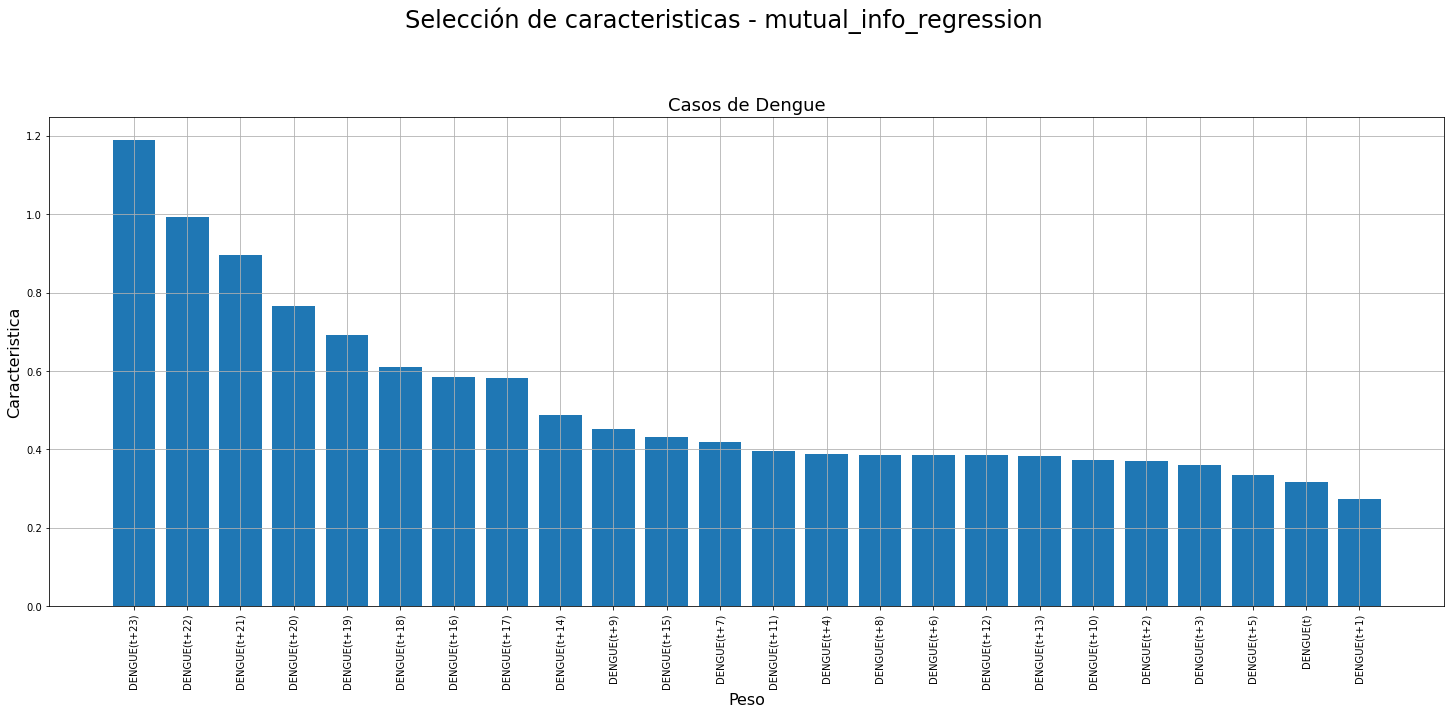

In [24]:
n=n_var-1 #numero caracteristicas
# Feature extraction
test = SelectKBest(score_func = mutual_info_regression, k=n) #cambiar score_func y k <- mejor segun grafica arriba
fit = test.fit(x, y)

# Summarize scores
np.set_printoptions(precision=3)
scores = test.scores_
mask = test.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature,score in zip(mask, feature_names,scores):
    if bool:
        new_features.append([feature,score])

CR1 = sorted(new_features, key = lambda x: x[1], reverse=True)
df_CR1 = pd.DataFrame(CR1)        
#print(f'{n} caracteristicas: ',CR)

df_CR1

#features = fit.transform(x)
# Summarize selected features
#print(features[0:5,:])





plt.figure(1,figsize=(25,9))
#ax = plt.gca()
plt.y_pos = np.arange(len(df_CR1))
X_indices = np.arange(len(df_CR1[0]))
features = df_CR1[0]
score_feature = df_CR1[1]
plt.bar(features, score_feature)
plt.xticks(X_indices, features, rotation='vertical', fontsize = 10)
plt.xlabel('Peso', fontsize = 16)
plt.ylabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - mutual_info_regression', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
# plt.xscale('log')
# plt.invert_yaxis()
plt.grid()
plt.savefig(PATH_O + 'Mutual_info_regression_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show()
df_CR1 
AAA = df_CR1

In [25]:
df_CR1.to_csv(PATH_O + 'caracteristicas_mutual_regresion.csv', index=True)

In [26]:
## f_classif

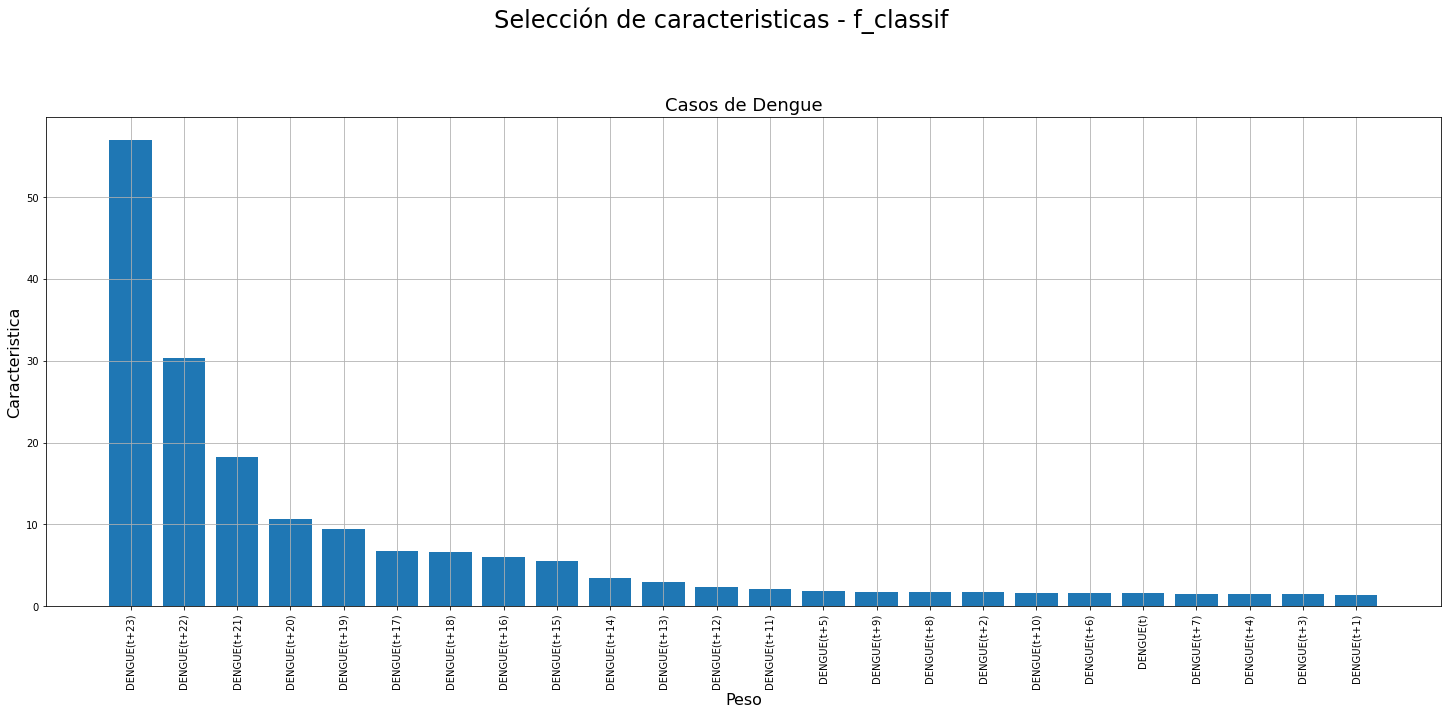

In [27]:
n=n_var-1 #numero caracteristicas
# Feature extraction
test = SelectKBest(score_func = f_classif, k=n) #cambiar score_func y k <- mejor segun grafica arriba
fit = test.fit(x, y)

# Summarize scores
np.set_printoptions(precision=3)
scores = test.scores_
mask = test.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature,score in zip(mask, feature_names,scores):
    if bool:
        new_features.append([feature,score])

        
CR2 = sorted(new_features, key = lambda x: x[1], reverse=True)
df_CR2 = pd.DataFrame(CR2)        
#print(f'{n} caracteristicas: ',CR)
df_CR2

#print(f'{n} caracteristicas: ',sorted(new_features, key = lambda x: x[1], reverse=True))




plt.figure(1,figsize=(25,9))
#ax = plt.gca()
plt.y_pos = np.arange(len(df_CR2))
X_indices = np.arange(len(df_CR2[0]))
features = df_CR2[0]
score_feature = df_CR2[1]
plt.bar(features, score_feature)
plt.xticks(X_indices, features, rotation='vertical', fontsize = 10)
plt.xlabel('Peso', fontsize = 16)
plt.ylabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - f_classif', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
#plt.xscale('log')
#plt.invert_yaxis()
plt.grid()
plt.savefig(PATH_O + 'f_classif_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show()
df_CR2 
BBB = df_CR2 


In [28]:
df_CR2.to_csv(PATH_O + 'caracteristicas_peso_f_clasif.csv', index=True)

In [29]:
## f_regression

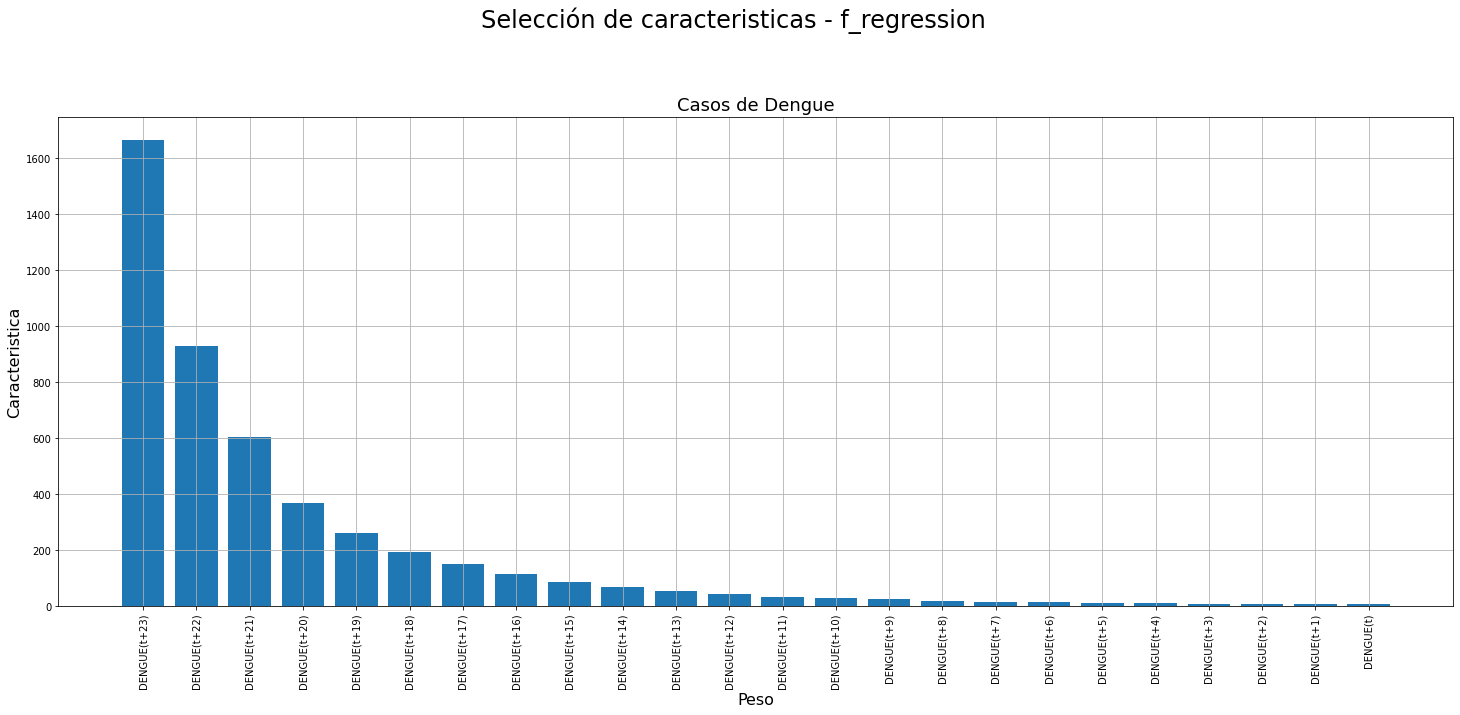

In [30]:
n=n_var-1 #numero caracteristicas
# Feature extraction
test = SelectKBest(score_func = f_regression, k=n) #cambiar score_func y k <- mejor segun grafica arriba
fit = test.fit(x, y)

# Summarize scores
np.set_printoptions(precision=3)
scores = test.scores_
mask = test.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature,score in zip(mask, feature_names,scores):
    if bool:
        new_features.append([feature,score])

CR3 = sorted(new_features, key = lambda x: x[1], reverse=True)
df_CR3 = pd.DataFrame(CR3)        
#print(f'{n} caracteristicas: ',CR)
        
#print(f'{n} caracteristicas: ',sorted(new_features, key = lambda x: x[1], reverse=True))




plt.figure(1,figsize=(25,9))
X_indices = np.arange(len(df_CR3[0]))
#ax = plt.gca()
plt.y_pos = np.arange(len(df_CR3))
features = df_CR3[0]
score_feature = df_CR3[1]
plt.bar(features, score_feature)
plt.xlabel('Peso', fontsize = 16)
plt.ylabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - f_regression', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.xticks(X_indices, features, rotation='vertical', fontsize = 10)

#ax.set_xscale('log')
#ax.invert_yaxis()
plt.grid()
plt.savefig(PATH_O + 'f_regression_ordenado.jpg', dpi=100, bbox_inches='tight')
plt.show()
df_CR3 
CCC = df_CR3

In [31]:
df_CR2.to_csv(PATH_O + 'caracteristicas_f_regression_ordenado.csv', index=True)

In [32]:
df_CR1.sort_values(0, inplace=True)
AAA1 = df_CR1

df_CR2.sort_values(0, inplace=True)
BBB1 = df_CR2

df_CR3.sort_values(0, inplace=True)
CCC1 = df_CR3

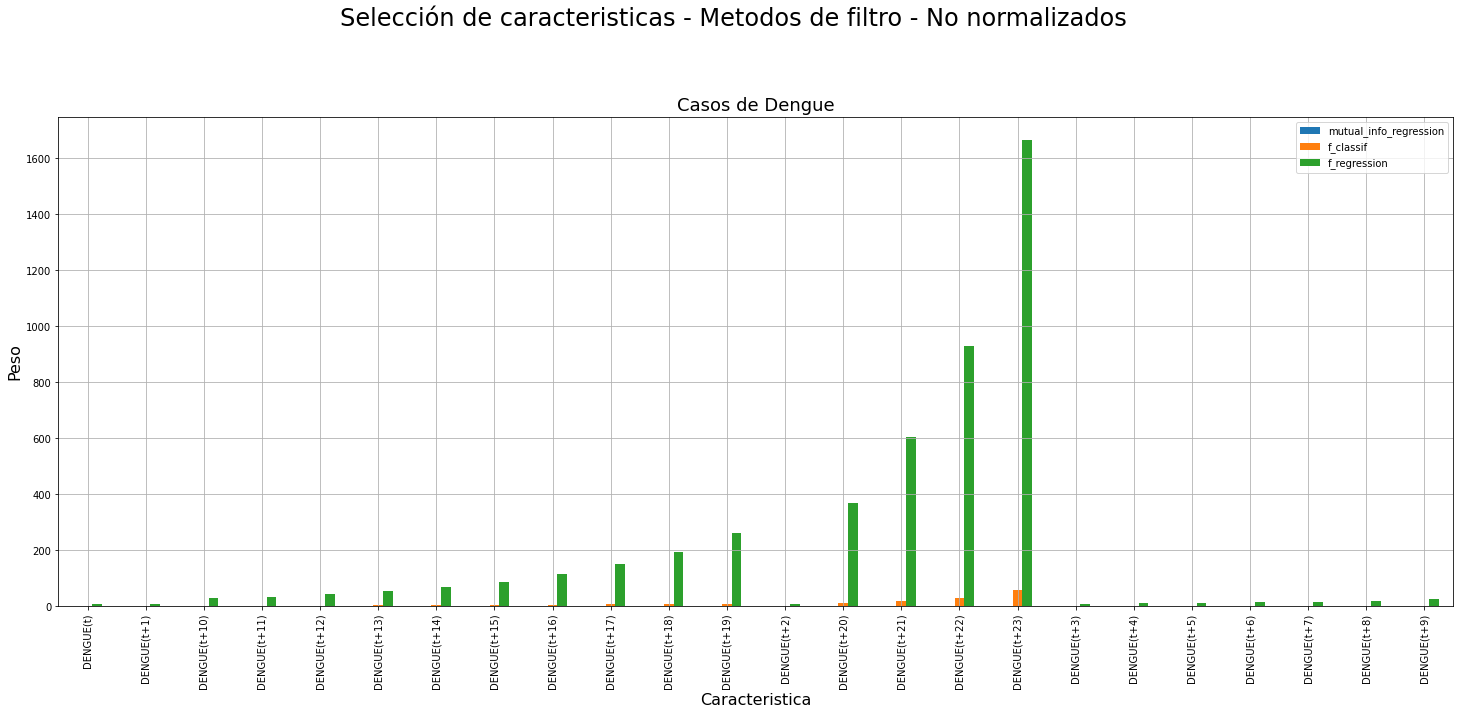

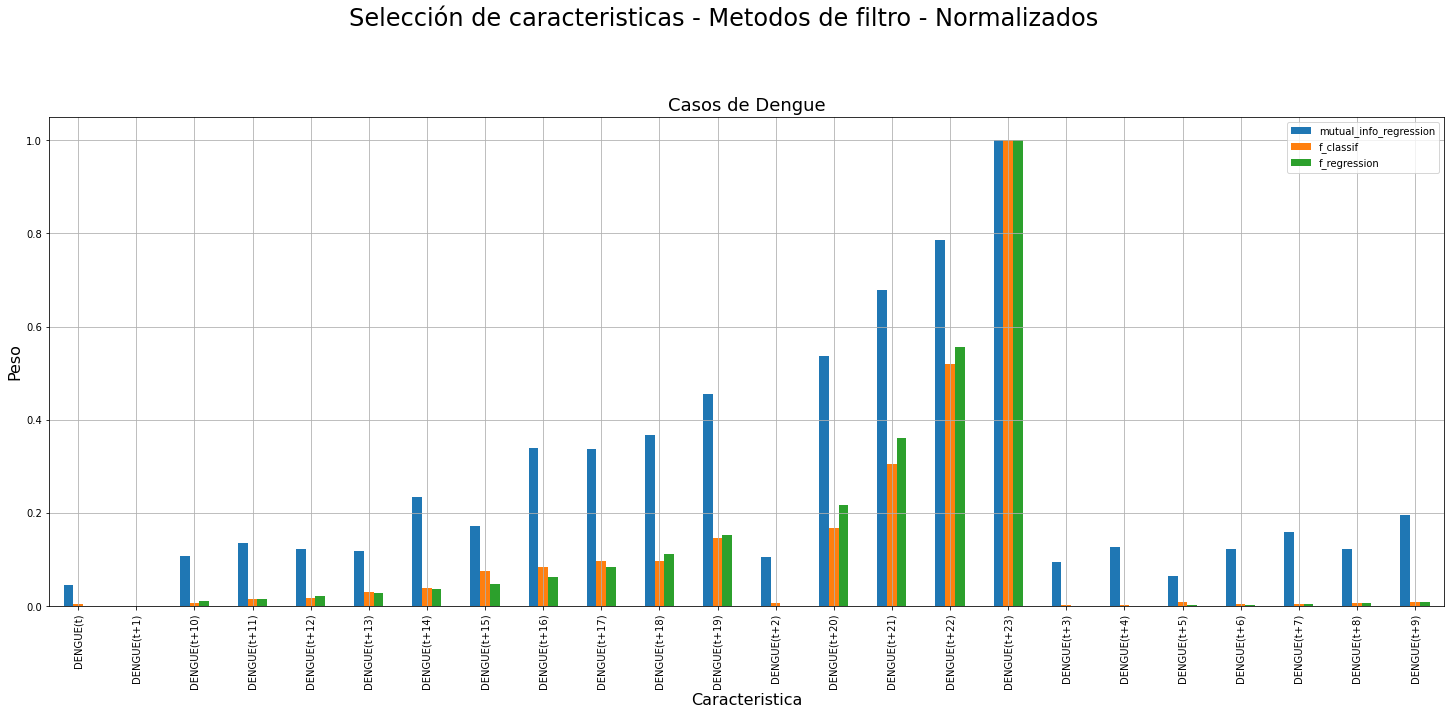

In [33]:
LLL1 = np.reshape(AAA1.values[:,0],(len(AAA1),1))
AAA1_V = np.reshape(AAA1.values[:,1],(len(AAA1),1))
AAA1_S = escalador(AAA1_V, np.amin(AAA1_V), np.amax(AAA1_V))
BBB1_V = np.reshape(BBB1.values[:,1],(len(AAA1),1))
BBB1_S = escalador(BBB1_V, np.amin(BBB1_V), np.amax(BBB1_V))
CCC1_V = np.reshape(CCC1.values[:,1],(len(AAA1),1))
CCC1_S = escalador(CCC1_V, np.amin(CCC1_V), np.amax(CCC1_V))
carac = np.append(LLL1,AAA1_V,axis=1)
carac = np.append(carac,BBB1_V,axis=1)
carac = np.append(carac,CCC1_V,axis=1)
Escal = AAA1_S + BBB1_S + CCC1_S

carac

Escalados = np.append(LLL1,Escal,axis=1)
Escalados

C0 = list(carac[:,0])
C1 = list(carac[:,1])
C2 = list(carac[:,2])
C3 = list(carac[:,3])



Caracteristicas_sin_escala = pd.DataFrame({'Caracteristica': C0, 'mutual_info_regression' : C1, 'f_classif' : C2, 'f_regression': C3})
Caracteristicas_sin_escala.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caracteristicas_sin_escala))
plt.xticks(X_indices, Caracteristicas_sin_escala['Caracteristica'], rotation='vertical', fontsize = 10)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Metodos de filtro - No normalizados', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-NO-Normalizados.jpg', dpi=100, bbox_inches='tight')
plt.show()

carac_s = np.append(LLL1,AAA1_S,axis=1)
carac_s = np.append(carac_s,BBB1_S,axis=1)
carac_s = np.append(carac_s,CCC1_S,axis=1)
C0_S = list(carac_s[:,0])
C1_S = list(carac_s[:,1])
C2_S = list(carac_s[:,2])
C3_S = list(carac_s[:,3])

Caracteristicas_escalado = pd.DataFrame({'Caracteristica': C0_S, 'mutual_info_regression' : C1_S, 'f_classif' : C2_S, 'f_regression': C3_S})
Caracteristicas_escalado.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caracteristicas_escalado))
plt.xticks(X_indices, Caracteristicas_escalado['Caracteristica'], rotation='vertical', fontsize = 10)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Metodos de filtro - Normalizados', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-Normalizados.jpg', dpi=100, bbox_inches='tight')
plt.show()
#pd.concat([df_CR1,df_CR2,df_CR3], ignore_index=True, axis=1)

# limite_caracteristica = np.array(([np.amin(caracteristicas_v[:,0])],[np.amax(caracteristicas_v[:,0])]))
# scaled_feature[:,i]=escalador(caracteristicas_v[:,i],limite_caracteristica[0][i],limite_caracteristica[1][i])

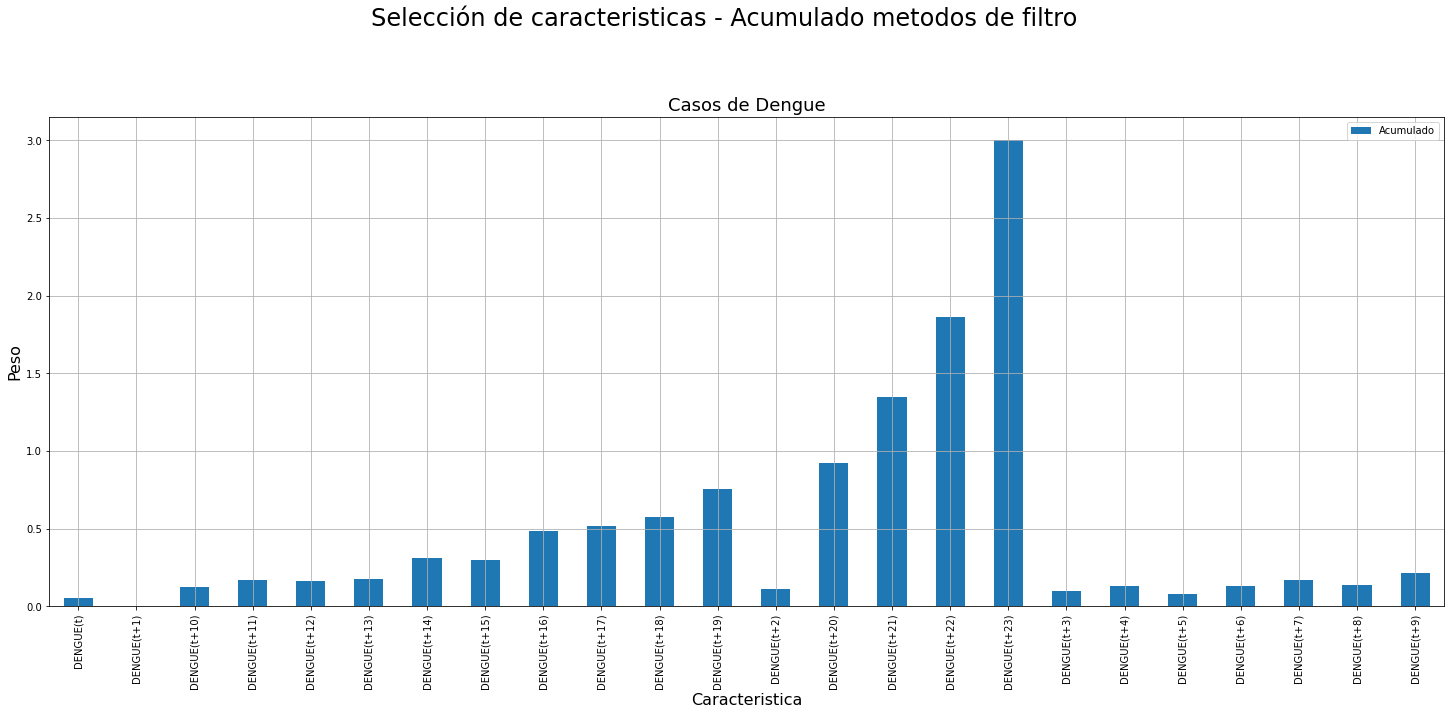

(7, 2)


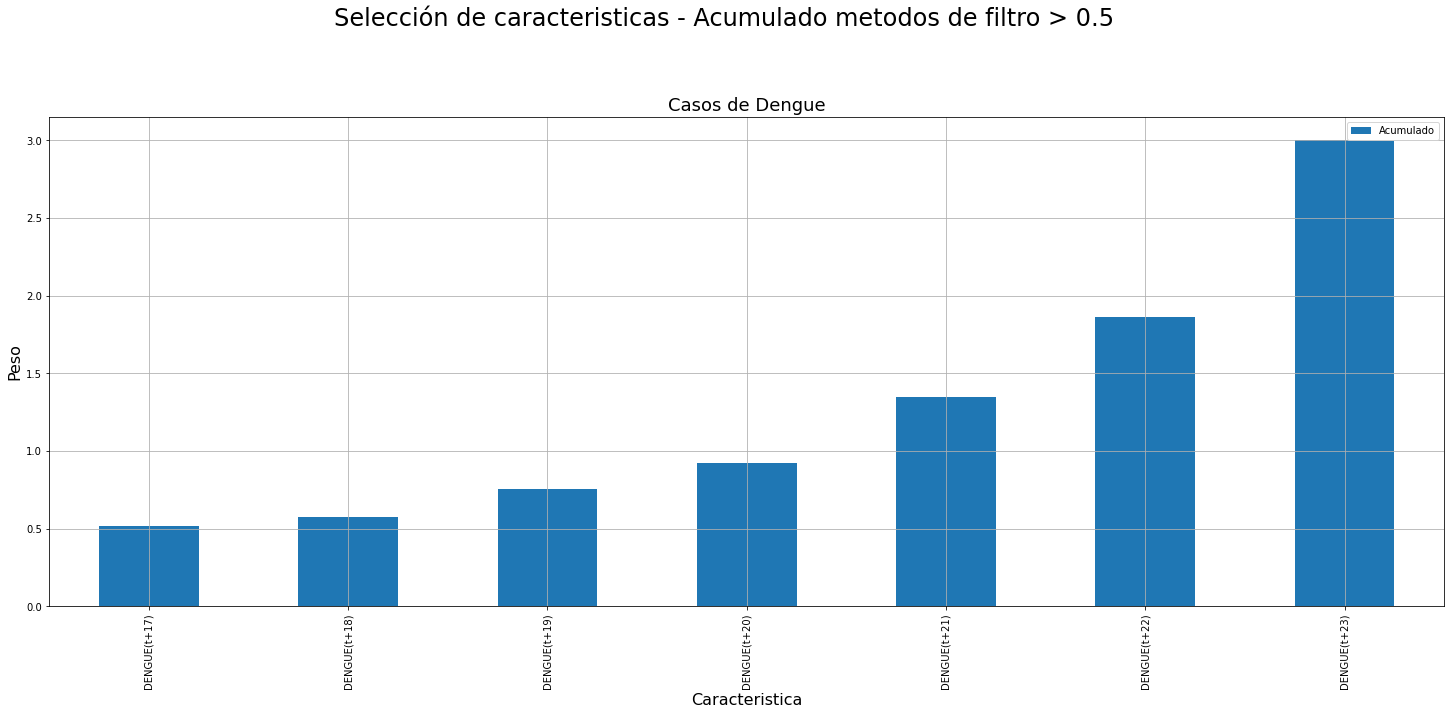

In [34]:
Escalados1 = list(Escalados[:,0])
Escalados2 = list(Escalados[:,1])
Caract_Escal = pd.DataFrame({'Caracteristica': Escalados1, 'Acumulado': Escalados2})
Caract_Escal

Caract_Escal.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caract_Escal))
plt.xticks(X_indices, Caract_Escal['Caracteristica'], rotation='vertical', fontsize = 10)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Acumulado metodos de filtro', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-Acumulaos.jpg', dpi=100, bbox_inches='tight')
plt.show()

Caract_Escal_Filtado = Caract_Escal[Caract_Escal['Acumulado']>0.5]
print(Caract_Escal_Filtado.shape)

Caract_Escal_Filtado.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caract_Escal_Filtado))
plt.xticks(X_indices, Caract_Escal_Filtado['Caracteristica'], rotation='vertical', fontsize = 10)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Acumulado metodos de filtro > 0.5', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-Acumulados_mas_05.jpg', dpi=100, bbox_inches='tight')
plt.show()
#Caract_Escal_Filtado

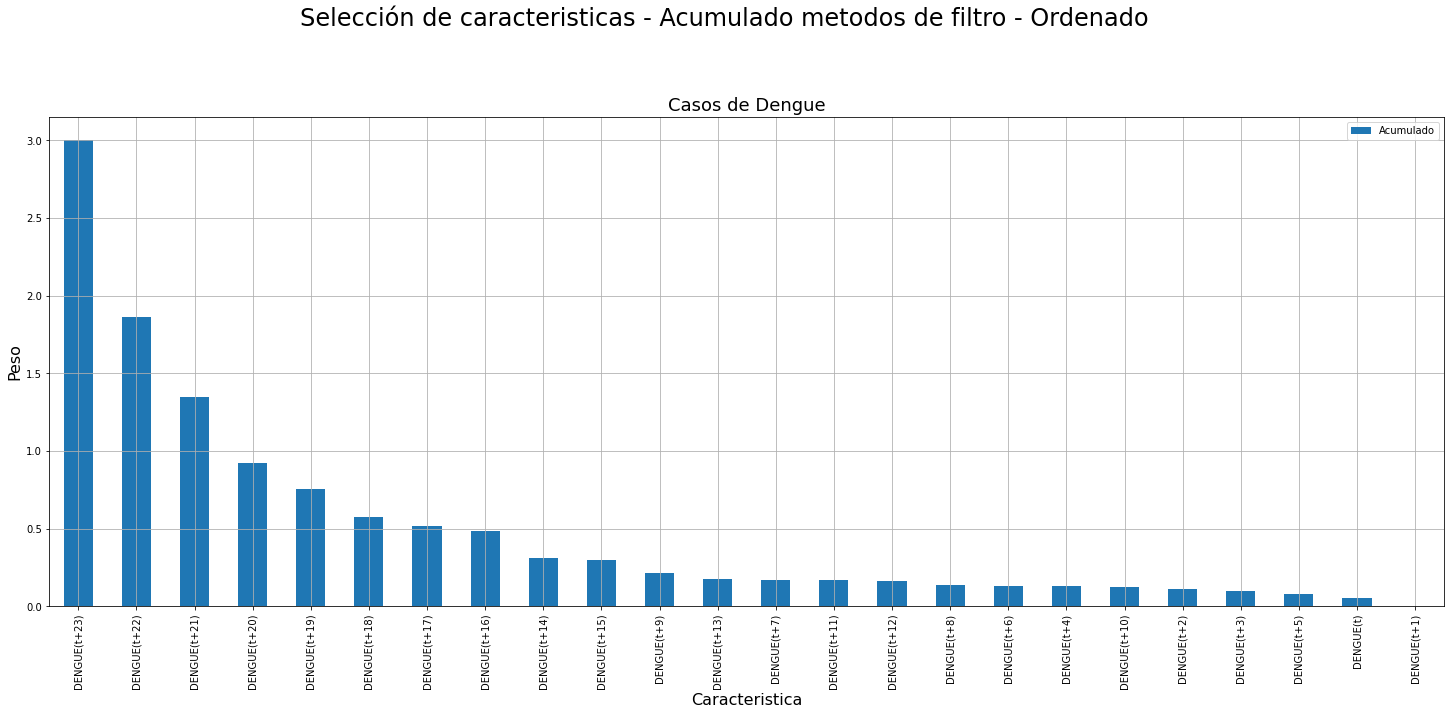

In [35]:

Caract_Escal_ORDEN = Caract_Escal.sort_values('Acumulado',ascending=False)


Caract_Escal_ORDEN.plot.bar(figsize = (25,9))
X_indices = np.arange(len(Caract_Escal_ORDEN))
plt.xticks(X_indices, Caract_Escal_ORDEN['Caracteristica'], rotation='vertical', fontsize = 10)
plt.ylabel('Peso', fontsize = 16)
plt.xlabel('Caracteristica', fontsize = 16)
plt.suptitle('Selección de caracteristicas - Acumulado metodos de filtro - Ordenado', y=1.05, fontsize = 24) 
plt.title(title_string, fontsize=18)
plt.grid()
plt.savefig(PATH_O + 'Metodos_de_filtro-Acumulados_Ordenados.jpg', dpi=100, bbox_inches='tight')
plt.show()

Caract_Escal_ORDEN.to_csv(PATH_O + 'caracteristicas_filtro_acumulado_ordenado.csv', index=True)

In [36]:
# for i in range (0,len(Escalados)):
#     if (Escalados[[i],[1]]>=0.5):
#         print(Escalados[[i],[0]], "\t\t\t\t", Escalados[[i],[1]])

In [37]:
# Escalados = Escalados[Escalados[:,1].argsort(),]
# #print(Escalados)
# Escalados = Escalados[::-1]
# #print(Escalados)
# Caracteristicas_orden = list(Escalados[:,0])
# #print(Caracteristicas_orden)
# Data_orden = df[Caracteristicas_orden]
# Data_orden




In [38]:
# caracteristicas_s = pd.concat([df_CR1,df_CR2,df_CR3], ignore_index=True, axis=1)
# caracteristicas_s



In [39]:
# feature_name = caracteristicas_s[2]
# del caracteristicas_s[2]
# del caracteristicas_s[4]
# caracteristicas_s.set_index([0],inplace=True)
# caracteristicas_s=caracteristicas_s.rename(columns={1: "mutual_info_regression", 3: "f_classif", 5:"f_regression"})
# caracteristicas_s.to_csv(PATH_O + "caracterisitcas_ordenadas.csv", index=True)
# caracteristicas_s

In [40]:
# caracteristicas_v = caracteristicas_s.values

# #Crear una matriz con los limites para el esclalado de los datos
# limite_caracteristica = np.array(([np.amin(caracteristicas_v[:,0])],[np.amax(caracteristicas_v[:,0])]))

# for i in range(1,len(caracteristicas_v[1,:])):
#     limite_caracteristica = np.insert(limite_caracteristica, limite_caracteristica.shape[1], [np.amin(caracteristicas_v[:,i]), np.amax(caracteristicas_v[:,i])], axis=1)


# scaled_feature = np.zeros((len(caracteristicas_v), len(caracteristicas_v[0])))
# for i in range(0,len(caracteristicas_v[1,:])):
#     scaled_feature[:,i]=escalador(caracteristicas_v[:,i],limite_caracteristica[0][i],limite_caracteristica[1][i])

# caracteristicas_v = pd.DataFrame(scaled_feature)

# caracteristicas_v = pd.concat([feature_name,caracteristicas_v], ignore_index=True, axis=1)
# caracteristicas_v.set_index([0],inplace=True)
# caracteristicas_v=caracteristicas_v.rename(columns={1: "mutual_info_regression", 2: "f_classif", 3:"f_regression"})
# caracteristicas_v.to_csv(PATH_O + "caracterisitcas_ord_normal.csv", index=True)
# caracteristicas_v
# acumulado = caracteristicas_v['mutual_info_regression']+caracteristicas_v['f_classif']+caracteristicas_v['f_regression']
# acumulado
# # acumulado.plot.bar(figsize = (15,5))
# # # X_indices = np.arange(len(acumulado))
# # # plt.xticks(X_indices, acumulado[0], rotation='vertical', fontsize = 8)
# # plt.ylabel('Peso', fontsize = 16)
# # plt.xlabel('Caracteristica', fontsize = 16)
# # plt.title('Selección de caracteristicas - Acumulado metodos de filtro Alejo', fontsize = 24) 
# # plt.grid()
# # # plt.savefig(PATH_O + 'acumulados_16.jpg', dpi=300)
# # plt.show()

In [41]:
# caracteristicas_s.plot.barh(figsize = (10,55))

In [42]:
# caracteristicas_v.plot.barh(figsize = (10,55))

In [43]:

#para capturar las caracteristicas deseadas
#caracteristicas_v.loc[['ONI(t+15)', 'ONI(t+11)', 'ONI(t+7)', 'ONI(t+3)', 'MEI(t+15)', 'MEI(t+11)', 'MEI(t+7)', 'MEI(t+3)', 'SST4(t+15)', 'SST4(t+11)', 'SST4(t+7)', 'SST4(t+3)', 'TNI(t+15)', 'TNI(t+11)', 'TNI(t+7)', 'TNI(t+3)', 'SST3(t+15)', 'SST3(t+11)', 'SST3(t+7)', 'SST3(t+3)', 'SST3.4(t+15)', 'SST3.4(t+11)', 'SST3.4(t+7)', 'SST3.4(t+3)', 'SST1+2(t+15)', 'SST1+2(t+11)', 'SST1+2(t+7)', 'SST1+2(t+3)', 'TEMPERATURE_AMAX(t+15)', 'TEMPERATURE_AMAX(t+14)', 'TEMPERATURE_AMAX(t+13)', 'TEMPERATURE_AMAX(t+12)', 'TEMPERATURE_AMAX(t+11)', 'TEMPERATURE_AMAX(t+10)', 'TEMPERATURE_AMAX(t+9)', 'TEMPERATURE_AMAX(t+8)', 'TEMPERATURE_AMAX(t+7)', 'TEMPERATURE_AMAX(t+6)', 'TEMPERATURE_AMAX(t+5)', 'TEMPERATURE_AMAX(t+4)', 'TEMPERATURE_AMAX(t+3)', 'TEMPERATURE_AMAX(t+2)', 'TEMPERATURE_AMAX(t+1)', 'TEMPERATURE_AMAX(t)', 'TEMPERATURE_MEAN(t+15)', 'TEMPERATURE_MEAN(t+14)', 'TEMPERATURE_MEAN(t+13)', 'TEMPERATURE_MEAN(t+12)', 'TEMPERATURE_MEAN(t+11)', 'TEMPERATURE_MEAN(t+10)', 'TEMPERATURE_MEAN(t+9)', 'TEMPERATURE_MEAN(t+8)', 'TEMPERATURE_MEAN(t+7)', 'TEMPERATURE_MEAN(t+6)', 'TEMPERATURE_MEAN(t+5)', 'TEMPERATURE_MEAN(t+4)', 'TEMPERATURE_MEAN(t+3)', 'TEMPERATURE_MEAN(t+2)', 'TEMPERATURE_MEAN(t+1)', 'TEMPERATURE_MEAN(t)', 'TEMPERATURE_RANGE(t+15)', 'TEMPERATURE_RANGE(t+14)', 'TEMPERATURE_RANGE(t+13)', 'TEMPERATURE_RANGE(t+12)', 'TEMPERATURE_RANGE(t+11)', 'TEMPERATURE_RANGE(t+10)', 'TEMPERATURE_RANGE(t+9)', 'TEMPERATURE_RANGE(t+8)', 'TEMPERATURE_RANGE(t+7)', 'TEMPERATURE_RANGE(t+6)', 'TEMPERATURE_RANGE(t+5)', 'TEMPERATURE_RANGE(t+4)', 'TEMPERATURE_RANGE(t+3)', 'TEMPERATURE_RANGE(t+2)', 'TEMPERATURE_RANGE(t+1)', 'TEMPERATURE_RANGE(t)', 'REL_HUMIDITY_AMAX(t+15)', 'REL_HUMIDITY_AMAX(t+14)', 'REL_HUMIDITY_AMAX(t+13)', 'REL_HUMIDITY_AMAX(t+12)', 'REL_HUMIDITY_AMAX(t+11)', 'REL_HUMIDITY_AMAX(t+10)', 'REL_HUMIDITY_AMAX(t+9)', 'REL_HUMIDITY_AMAX(t+8)', 'REL_HUMIDITY_AMAX(t+7)', 'REL_HUMIDITY_AMAX(t+6)', 'REL_HUMIDITY_AMAX(t+5)', 'REL_HUMIDITY_AMAX(t+4)', 'REL_HUMIDITY_AMAX(t+3)', 'REL_HUMIDITY_AMAX(t+2)', 'REL_HUMIDITY_AMAX(t+1)', 'REL_HUMIDITY_AMAX(t)',  'REL_HUMIDITY_MEAN(t+15)', 'REL_HUMIDITY_MEAN(t+14)', 'REL_HUMIDITY_MEAN(t+13)', 'REL_HUMIDITY_MEAN(t+12)', 'REL_HUMIDITY_MEAN(t+11)', 'REL_HUMIDITY_MEAN(t+10)', 'REL_HUMIDITY_MEAN(t+9)', 'REL_HUMIDITY_MEAN(t+8)', 'REL_HUMIDITY_MEAN(t+7)', 'REL_HUMIDITY_MEAN(t+6)', 'REL_HUMIDITY_MEAN(t+5)', 'REL_HUMIDITY_MEAN(t+4)', 'REL_HUMIDITY_MEAN(t+3)', 'REL_HUMIDITY_MEAN(t+2)', 'REL_HUMIDITY_MEAN(t+1)', 'REL_HUMIDITY_MEAN(t)', 'DENGUE(t+15)', 'DENGUE(t+14)', 'DENGUE(t+13)', 'DENGUE(t+12)', 'DENGUE(t+11)', 'DENGUE(t+10)', 'DENGUE(t+9)', 'DENGUE(t+8)', 'DENGUE(t+7)', 'DENGUE(t+6)', 'DENGUE(t+5)', 'DENGUE(t+4)', 'DENGUE(t+3)', 'DENGUE(t+2)', 'DENGUE(t+1)', 'DENGUE(t)']]


In [44]:
#df_CR3.to_csv(PATH_O + 'caracteristicas_f_regresion.csv', index=True)

In [45]:
# caracteristicas = pd.concat([df_CR1,df_CR2,df_CR3], ignore_index=True, axis=1)
# caracteristicas.to_csv(nombre_a, index=True)
# caracteristicas

In [46]:
# caracteristicas.to_csv(PATH_O + 'caracteristicas_TODAS_CARACTERISTICAS.csv', index=True)

In [47]:
#XD = df[['ONI(t+16)', 'ONI(t+12)', 'ONI(t+8)', 'ONI(t+4)', 'ONI(t)', 'MEI(t+16)', 'MEI(t+12)', 'MEI(t+8)', 'MEI(t+4)', 'MEI(t)', 'SST4(t+16)', 'SST4(t+12)', 'SST4(t+8)', 'SST4(t+4)', 'SST4(t)', 'TNI(t+16)', 'TNI(t+12)', 'TNI(t+8)', 'TNI(t+4)', 'TNI(t)',  'SST3.4(t+16)', 'SST3.4(t+12)', 'SST3.4(t+8)', 'SST3.4(t+4)', 'SST3.4(t)', 'SST3.4(t+16)', 'SST3.4(t+12)', 'SST3.4(t+8)', 'SST3.4(t+4)', 'SST3.4(t)', 'TEMPERATURE_AMAX(t+16)', 'TEMPERATURE_AMAX(t+15)', 'TEMPERATURE_AMAX(t+14)', 'TEMPERATURE_AMAX(t+13)', 'TEMPERATURE_AMAX(t+12)', 'TEMPERATURE_AMAX(t+11)', 'TEMPERATURE_AMAX(t+10)', 'TEMPERATURE_AMAX(t+9)', 'TEMPERATURE_AMAX(t+8)', 'TEMPERATURE_AMAX(t+7)', 'TEMPERATURE_AMAX(t+6)', 'TEMPERATURE_AMAX(t+5)', 'TEMPERATURE_AMAX(t+4)', 'TEMPERATURE_AMAX(t+3)', 'TEMPERATURE_AMAX(t+2)', 'TEMPERATURE_AMAX(t+1)', 'TEMPERATURE_AMAX(t)', 'TEMPERATURE_MEAN(t+16)', 'TEMPERATURE_MEAN(t+15)', 'TEMPERATURE_MEAN(t+14)', 'TEMPERATURE_MEAN(t+13)', 'TEMPERATURE_MEAN(t+12)', 'TEMPERATURE_MEAN(t+11)', 'TEMPERATURE_MEAN(t+10)', 'TEMPERATURE_MEAN(t+9)', 'TEMPERATURE_MEAN(t+8)', 'TEMPERATURE_MEAN(t+7)', 'TEMPERATURE_MEAN(t+6)', 'TEMPERATURE_MEAN(t+5)', 'TEMPERATURE_MEAN(t+4)', 'TEMPERATURE_MEAN(t+3)', 'TEMPERATURE_MEAN(t+2)', 'TEMPERATURE_MEAN(t+1)', 'TEMPERATURE_MEAN(t)', 'TEMPERATURE_RANGE(t+16)', 'TEMPERATURE_RANGE(t+15)', 'TEMPERATURE_RANGE(t+14)', 'TEMPERATURE_RANGE(t+13)', 'TEMPERATURE_RANGE(t+12)', 'TEMPERATURE_RANGE(t+11)', 'TEMPERATURE_RANGE(t+10)', 'TEMPERATURE_RANGE(t+9)', 'TEMPERATURE_RANGE(t+8)', 'TEMPERATURE_RANGE(t+7)', 'TEMPERATURE_RANGE(t+6)', 'TEMPERATURE_RANGE(t+5)', 'TEMPERATURE_RANGE(t+4)', 'TEMPERATURE_RANGE(t+3)', 'TEMPERATURE_RANGE(t+2)', 'TEMPERATURE_RANGE(t+1)', 'TEMPERATURE_RANGE(t)', 'SST1+2(t+16)', 'SST1+2(t+12)', 'SST1+2(t+8)', 'SST1+2(t+4)', 'SST1+2(t)', 'REL_HUMIDITY_AMAX(t+16)', 'REL_HUMIDITY_AMAX(t+15)', 'REL_HUMIDITY_AMAX(t+14)', 'REL_HUMIDITY_AMAX(t+13)', 'REL_HUMIDITY_AMAX(t+12)', 'REL_HUMIDITY_AMAX(t+11)', 'REL_HUMIDITY_AMAX(t+10)', 'REL_HUMIDITY_AMAX(t+9)', 'REL_HUMIDITY_AMAX(t+8)', 'REL_HUMIDITY_AMAX(t+7)', 'REL_HUMIDITY_AMAX(t+6)', 'REL_HUMIDITY_AMAX(t+5)', 'REL_HUMIDITY_AMAX(t+4)', 'REL_HUMIDITY_AMAX(t+3)', 'REL_HUMIDITY_AMAX(t+2)', 'REL_HUMIDITY_AMAX(t+1)', 'REL_HUMIDITY_AMAX(t)', 'REL_HUMIDITY_MEAN(t+16)', 'REL_HUMIDITY_MEAN(t+15)', 'REL_HUMIDITY_MEAN(t+14)', 'REL_HUMIDITY_MEAN(t+13)', 'REL_HUMIDITY_MEAN(t+12)', 'REL_HUMIDITY_MEAN(t+11)', 'REL_HUMIDITY_MEAN(t+10)', 'REL_HUMIDITY_MEAN(t+9)', 'REL_HUMIDITY_MEAN(t+8)', 'REL_HUMIDITY_MEAN(t+7)', 'REL_HUMIDITY_MEAN(t+6)', 'REL_HUMIDITY_MEAN(t+5)', 'REL_HUMIDITY_MEAN(t+4)', 'REL_HUMIDITY_MEAN(t+3)', 'REL_HUMIDITY_MEAN(t+2)', 'REL_HUMIDITY_MEAN(t+1)', 'REL_HUMIDITY_MEAN(t)', 'DENGUE(t+16)', 'DENGUE(t+15)', 'DENGUE(t+14)', 'DENGUE(t+13)', 'DENGUE(t+12)', 'DENGUE(t+11)', 'DENGUE(t+10)', 'DENGUE(t+9)', 'DENGUE(t+8)', 'DENGUE(t+7)', 'DENGUE(t+6)', 'DENGUE(t+5)', 'DENGUE(t+4)', 'DENGUE(t+3)', 'DENGUE(t+2)', 'DENGUE(t+1)']]
# SX = df[['ONI(t+15)', 'ONI(t+11)', 'ONI(t+7)', 'ONI(t+3)', 'MEI(t+15)', 'MEI(t+11)', 'MEI(t+7)', 'MEI(t+3)', 'SST4(t+15)', 'SST4(t+11)', 'SST4(t+7)', 'SST4(t+3)', 'TNI(t+15)', 'TNI(t+11)', 'TNI(t+7)', 'TNI(t+3)', 'SST3(t+15)', 'SST3(t+11)', 'SST3(t+7)', 'SST3(t+3)', 'SST3.4(t+15)', 'SST3.4(t+11)', 'SST3.4(t+7)', 'SST3.4(t+3)', 'SST1+2(t+15)', 'SST1+2(t+11)', 'SST1+2(t+7)', 'SST1+2(t+3)', 'TEMPERATURE_AMAX(t+15)', 'TEMPERATURE_AMAX(t+14)', 'TEMPERATURE_AMAX(t+13)', 'TEMPERATURE_AMAX(t+12)', 'TEMPERATURE_AMAX(t+11)', 'TEMPERATURE_AMAX(t+10)', 'TEMPERATURE_AMAX(t+9)', 'TEMPERATURE_AMAX(t+8)', 'TEMPERATURE_AMAX(t+7)', 'TEMPERATURE_AMAX(t+6)', 'TEMPERATURE_AMAX(t+5)', 'TEMPERATURE_AMAX(t+4)', 'TEMPERATURE_AMAX(t+3)', 'TEMPERATURE_AMAX(t+2)', 'TEMPERATURE_AMAX(t+1)', 'TEMPERATURE_AMAX(t)', 'TEMPERATURE_MEAN(t+15)', 'TEMPERATURE_MEAN(t+14)', 'TEMPERATURE_MEAN(t+13)', 'TEMPERATURE_MEAN(t+12)', 'TEMPERATURE_MEAN(t+11)', 'TEMPERATURE_MEAN(t+10)', 'TEMPERATURE_MEAN(t+9)', 'TEMPERATURE_MEAN(t+8)', 'TEMPERATURE_MEAN(t+7)', 'TEMPERATURE_MEAN(t+6)', 'TEMPERATURE_MEAN(t+5)', 'TEMPERATURE_MEAN(t+4)', 'TEMPERATURE_MEAN(t+3)', 'TEMPERATURE_MEAN(t+2)', 'TEMPERATURE_MEAN(t+1)', 'TEMPERATURE_MEAN(t)', 'TEMPERATURE_RANGE(t+15)', 'TEMPERATURE_RANGE(t+14)', 'TEMPERATURE_RANGE(t+13)', 'TEMPERATURE_RANGE(t+12)', 'TEMPERATURE_RANGE(t+11)', 'TEMPERATURE_RANGE(t+10)', 'TEMPERATURE_RANGE(t+9)', 'TEMPERATURE_RANGE(t+8)', 'TEMPERATURE_RANGE(t+7)', 'TEMPERATURE_RANGE(t+6)', 'TEMPERATURE_RANGE(t+5)', 'TEMPERATURE_RANGE(t+4)', 'TEMPERATURE_RANGE(t+3)', 'TEMPERATURE_RANGE(t+2)', 'TEMPERATURE_RANGE(t+1)', 'TEMPERATURE_RANGE(t)', 'REL_HUMIDITY_AMAX(t+15)', 'REL_HUMIDITY_AMAX(t+14)', 'REL_HUMIDITY_AMAX(t+13)', 'REL_HUMIDITY_AMAX(t+12)', 'REL_HUMIDITY_AMAX(t+11)', 'REL_HUMIDITY_AMAX(t+10)', 'REL_HUMIDITY_AMAX(t+9)', 'REL_HUMIDITY_AMAX(t+8)', 'REL_HUMIDITY_AMAX(t+7)', 'REL_HUMIDITY_AMAX(t+6)', 'REL_HUMIDITY_AMAX(t+5)', 'REL_HUMIDITY_AMAX(t+4)', 'REL_HUMIDITY_AMAX(t+3)', 'REL_HUMIDITY_AMAX(t+2)', 'REL_HUMIDITY_AMAX(t+1)', 'REL_HUMIDITY_AMAX(t)',  'REL_HUMIDITY_MEAN(t+15)', 'REL_HUMIDITY_MEAN(t+14)', 'REL_HUMIDITY_MEAN(t+13)', 'REL_HUMIDITY_MEAN(t+12)', 'REL_HUMIDITY_MEAN(t+11)', 'REL_HUMIDITY_MEAN(t+10)', 'REL_HUMIDITY_MEAN(t+9)', 'REL_HUMIDITY_MEAN(t+8)', 'REL_HUMIDITY_MEAN(t+7)', 'REL_HUMIDITY_MEAN(t+6)', 'REL_HUMIDITY_MEAN(t+5)', 'REL_HUMIDITY_MEAN(t+4)', 'REL_HUMIDITY_MEAN(t+3)', 'REL_HUMIDITY_MEAN(t+2)', 'REL_HUMIDITY_MEAN(t+1)', 'REL_HUMIDITY_MEAN(t)', 'DENGUE(t+15)', 'DENGUE(t+14)', 'DENGUE(t+13)', 'DENGUE(t+12)', 'DENGUE(t+11)', 'DENGUE(t+10)', 'DENGUE(t+9)', 'DENGUE(t+8)', 'DENGUE(t+7)', 'DENGUE(t+6)', 'DENGUE(t+5)', 'DENGUE(t+4)', 'DENGUE(t+3)', 'DENGUE(t+2)', 'DENGUE(t+1)', 'DENGUE(t)']]
# SY = df[['DENGUE_ESPERADO']]
# SX.to_csv(PATH_O + 'Set_datos_X.csv', index=True)
# SY.to_csv(PATH_O + 'Set_datos_Y.csv', index=True)